[View in Colaboratory](https://colab.research.google.com/github/Joovvhan/ColabTest/blob/master/Transfer_Learning_Model_Comparison.ipynb)

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wf

In [10]:
os.listdir('gdrive/My Drive/Colab/Data')

['A3F1P3', 'A3F5P3', 'A3F3P1', 'A3F3P5', 'A5F3P3', 'A1F3P3']

In [0]:
dataPath = 'gdrive/My Drive/Colab/Data'

"""
folders = os.listdir(dataPath)

for folder in folders:
  files = os.listdir(dataPath + '/' + folder)
  print(len(files))
  print(files[-1])
"""

folderF1 = dataPath + '/' + 'A3F1P3'  
folderF5 = dataPath + '/' + 'A3F5P3'
filesF1 = os.listdir(folderF1)
filesF5 = os.listdir(folderF5)

folderA5 = dataPath + '/' + 'A5F3P3'
filesA5 = os.listdir(folderA5)

In [14]:
filesF1[0]

'A3.490879_F0.139398_P2.076554_H360.426598.wav'

In [0]:
fs, data = wf.read(folderF1 + '/' + filesF1[0])
data

dataScaled = data / (2 ** 15)

In [34]:
data

array([-3323, -2640, -3219, ...,   415,  -574, -1301], dtype=int16)

In [36]:
dataScaled

array([-0.10140991, -0.08056641, -0.09823608, ...,  0.01266479,
       -0.01751709, -0.03970337])

In [27]:
fs, data = wf.read(folderA5 + '/' + filesA5[0])
data

max(data)

7774

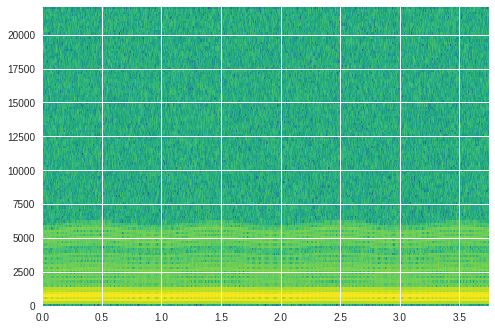

In [30]:
nsc = 256
nov = nsc/2
nff = nsc 

Pxx, freqs, bins, _ = plt.specgram(data, NFFT=nff, Fs=fs, noverlap=nov, window=np.hamming(nsc), cmap='viridis')

<module 'scipy.io.wavfile' from '/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py'>